IFU 결과:
                                           UNIQUE_ID     ifu_x     ifu_y
0  VH075030_PTVB827_3GJPBVH.VH075P_PTXV821_2024-0...  0.001692  0.002208
1  WC046030_PTXV831_54BPPWC.WC046P_DBF_PTVP841_20...  0.001233  0.001577
2  WF075030_PTVP841_5G4PPWF.WF075P_-_2024-07-16 2...  0.001616  0.001756

IWU 결과:
                                           UNIQUE_ID     iwu_x     iwu_y
0  VH075030_PTVB827_3GJPBVH.VH075P_PTXV821_2024-0...  0.002959  0.003143
1  WC046030_PTXV831_54BPPWC.WC046P_DBF_PTVP841_20...  0.001937  0.002036
2  WF075030_PTVP841_5G4PPWF.WF075P_-_2024-07-16 2...  0.004032  0.003747


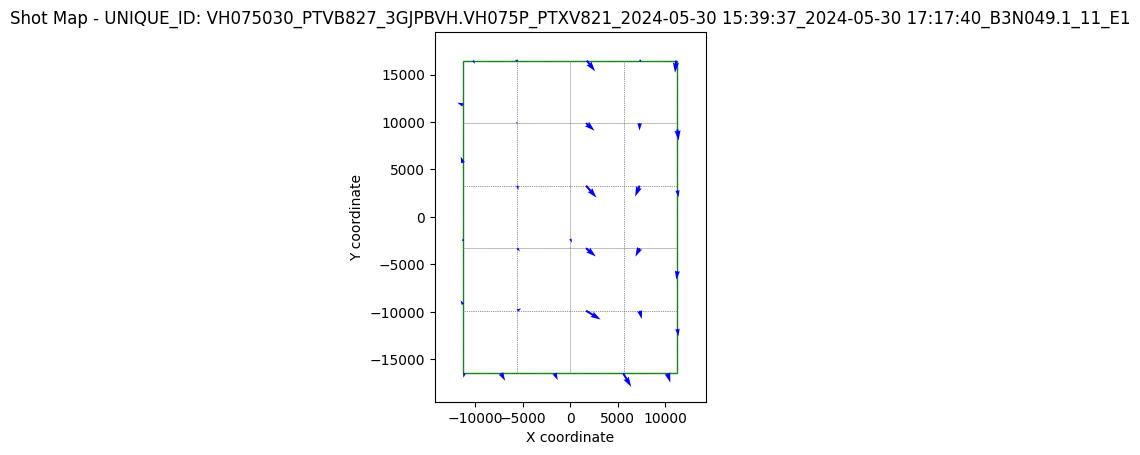

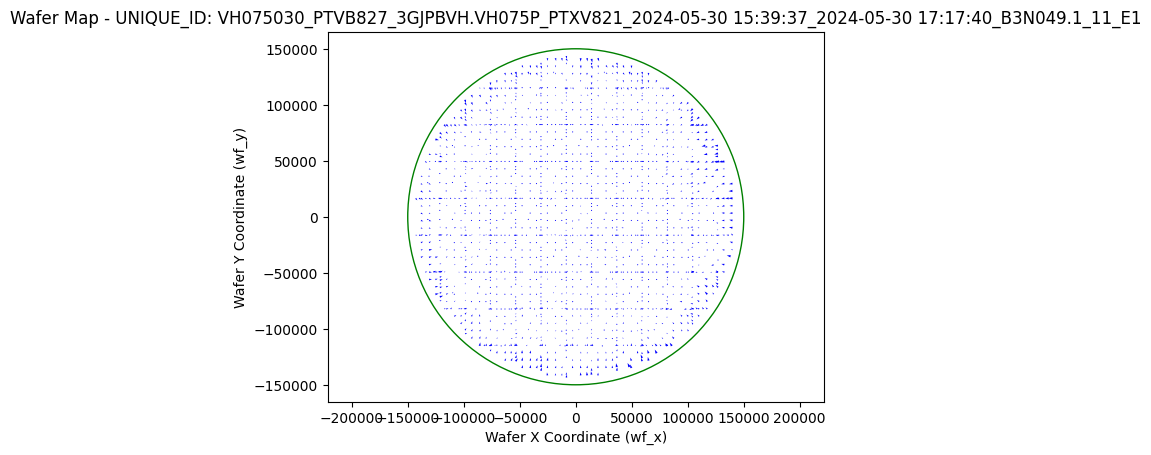

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def compute_is_partial_shot(df, wafer_radius):
    """
    각 샷이 Partial Shot인지 여부를 계산하고 데이터프레임에 추가합니다.
    """
    partial_shot_info = []

    # UNIQUE_ID별로 그룹화하여 STEP_PITCH 값을 사용
    for unique_id, group in df.groupby('UNIQUE_ID'):
        step_pitch_x_value = group['STEP_PITCH_X'].iloc[0]
        step_pitch_y_value = group['STEP_PITCH_Y'].iloc[0]
        
        for _, row in group.iterrows():
            dx, dy = row['DieX'], row['DieY']
            x, y = row['fcp_x'], row['fcp_y']
            
            bottom_left = (x - step_pitch_x_value / 2, y - step_pitch_y_value / 2)
            bottom_right = (x + step_pitch_x_value / 2, y - step_pitch_y_value / 2)
            top_left = (x - step_pitch_x_value / 2, y + step_pitch_y_value / 2)
            top_right = (x + step_pitch_x_value / 2, y + step_pitch_y_value / 2)
            
            corners = [bottom_left, bottom_right, top_left, top_right]
            distances = [np.sqrt(c[0]**2 + c[1]**2) for c in corners]
            
            is_partial = any(dist > wafer_radius for dist in distances)
            
            shot_info = {
                "UNIQUE_ID": unique_id,
                "DieX": dx, 
                "DieY": dy,
                "Is Partial Shot": is_partial,
            }
            
            partial_shot_info.append(shot_info)
    
    # partial_shot_info 리스트를 DataFrame으로 변환
    partial_shot_df = pd.DataFrame(partial_shot_info)
    

    # 기존 DataFrame과 Is Partial Shot 열을 병합
    df_merged = pd.concat([df, partial_shot_df['Is Partial Shot']], axis=1)

    return df_merged

def compute_non_partial_averages(df):
    """
    Partial Shot이 아닌 데이터에 대해 X_reg와 Y_reg의 평균을 계산합니다.
    """
    # Partial Shot이 아닌 데이터만 필터링
    df_non_partial = df[df['Is Partial Shot'] == False]
    
    # UNIQUE_ID, TEST, coordinate_X, coordinate_Y별로 평균 계산
    df_non_partial_avg = df_non_partial.groupby(['UNIQUE_ID', 'TEST', 'coordinate_X', 'coordinate_Y']).agg({
        'X_reg': 'mean',
        'Y_reg': 'mean',
        'STEP_PITCH_X': 'first',
        'STEP_PITCH_Y': 'first',
        'CHIP_X_NUM': 'first',
        'CHIP_Y_NUM': 'first'
    }).reset_index()
    df_non_partial_avg.rename(columns={'X_reg': 'X_reg_avg', 'Y_reg': 'Y_reg_avg'}, inplace=True)
    return df_non_partial_avg

def compute_ifu(df_non_partial_avg):
    """
    각 UNIQUE_ID별로 IFU_x와 IFU_y를 계산합니다.
    """
    ifu_values = []
    for unique_id, group in df_non_partial_avg.groupby('UNIQUE_ID'):
        mean_x = np.mean(group['X_reg_avg'])
        std_dev_x = np.std(group['X_reg_avg'])
        ifu_x = abs(mean_x) + (3 * std_dev_x)
        
        mean_y = np.mean(group['Y_reg_avg'])
        std_dev_y = np.std(group['Y_reg_avg'])
        ifu_y = abs(mean_y) + (3 * std_dev_y)
        
        ifu_values.append({'UNIQUE_ID': unique_id, 'ifu_x': ifu_x, 'ifu_y': ifu_y})
    df_ifu = pd.DataFrame(ifu_values)
    return df_ifu

def compute_iwu(df, df_non_partial_avg):
    """
    전체 데이터에서 IWU_x와 IWU_y를 계산합니다.
    """
    # 전체 데이터에 non_partial에서 계산한 평균값을 병합
    df_merged = pd.merge(df, df_non_partial_avg[['UNIQUE_ID', 'TEST', 'coordinate_X', 'coordinate_Y', 'X_reg_avg', 'Y_reg_avg']], 
                         on=['UNIQUE_ID', 'TEST', 'coordinate_X', 'coordinate_Y'], how='left')
    
    # X_reg_detrended 및 Y_reg_detrended 계산
    df_merged['X_reg_detrended'] = df_merged['X_reg'] - df_merged['X_reg_avg']
    df_merged['Y_reg_detrended'] = df_merged['Y_reg'] - df_merged['Y_reg_avg']
    
    # UNIQUE_ID별로 IWU 계산
    iwu_values = []
    for unique_id, group in df_merged.groupby('UNIQUE_ID'):
        # IWU_x 계산
        mean_detrended_x = np.mean(group['X_reg_detrended'].dropna())
        std_dev_detrended_x = np.std(group['X_reg_detrended'].dropna())
        iwu_x = abs(mean_detrended_x) + (3 * std_dev_detrended_x)
        
        # IWU_y 계산
        mean_detrended_y = np.mean(group['Y_reg_detrended'].dropna())
        std_dev_detrended_y = np.std(group['Y_reg_detrended'].dropna())
        iwu_y = abs(mean_detrended_y) + (3 * std_dev_detrended_y)
        
        iwu_values.append({'UNIQUE_ID': unique_id, 'iwu_x': iwu_x, 'iwu_y': iwu_y})
    df_iwu = pd.DataFrame(iwu_values)
    return df_iwu, df_merged

def plot_shot_map(df_avg, unique_id):
    """
    지정된 UNIQUE_ID에 대한 샷 맵을 그립니다.
    """
    df_subset = df_avg[df_avg['UNIQUE_ID'] == unique_id]
    if df_subset.empty:
        print(f"UNIQUE_ID {unique_id}에 대한 데이터가 없습니다.")
        return
    
    # 데이터 값들
    step_pitch_x = df_subset['STEP_PITCH_X'].iloc[0]
    step_pitch_y = df_subset['STEP_PITCH_Y'].iloc[0]
    chip_x_num = int(df_subset['CHIP_X_NUM'].iloc[0])
    chip_y_num = int(df_subset['CHIP_Y_NUM'].iloc[0])

    # shot의 중심 좌표
    shot_center_x = 0
    shot_center_y = 0

    # shot의 모서리 좌표 계산
    shot_left = shot_center_x - step_pitch_x / 2
    shot_bottom = shot_center_y - step_pitch_y / 2

    # chip의 크기 계산
    chip_width = step_pitch_x / chip_x_num
    chip_height = step_pitch_y / chip_y_num

    # 그림 그리기
    fig, ax = plt.subplots()

    # shot 사각형 그리기
    shot_rect = patches.Rectangle((shot_left, shot_bottom), step_pitch_x, step_pitch_y,
                                  linewidth=1, edgecolor='green', facecolor='none')
    ax.add_patch(shot_rect)

    # chip 경계선 점선으로 추가
    for i in range(chip_x_num):
        for j in range(chip_y_num):
            chip_left = shot_left + i * chip_width
            chip_bottom = shot_bottom + j * chip_height
            chip_rect = patches.Rectangle((chip_left, chip_bottom), chip_width, chip_height,
                                          linewidth=0.5, edgecolor='grey', linestyle='dotted', facecolor='none')
            ax.add_patch(chip_rect)

    # 평균 overlay 벡터 표시
    ax.quiver(df_subset['coordinate_X'], df_subset['coordinate_Y'], 
              df_subset['X_reg_avg'], df_subset['Y_reg_avg'], 
              angles='xy', scale_units='xy', scale=1e-6, color='blue')

    # 그래프 설정
    ax.set_xlim(shot_left - 3000, shot_left + step_pitch_x + 3000)
    ax.set_ylim(shot_bottom - 3000, shot_bottom + step_pitch_y + 3000)
    ax.set_aspect('equal')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title(f'Shot Map - UNIQUE_ID: {unique_id}')

    # 플롯 보여주기
    plt.show()

def plot_wafer_map(df, unique_id):
    """
    지정된 UNIQUE_ID에 대한 웨이퍼 맵을 그립니다.
    """
    df_subset = df[df['UNIQUE_ID'] == unique_id]
    if df_subset.empty:
        print(f"UNIQUE_ID {unique_id}에 대한 데이터가 없습니다.")
        return
    
    x = df_subset['wf_x']
    y = df_subset['wf_y']
    dx = df_subset['X_reg_detrended']
    dy = df_subset['Y_reg_detrended']

    # 그림 그리기
    fig, ax = plt.subplots()

    # Overlay 벡터 표시
    ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1e-6, color='blue')

    # 웨이퍼 경계선 추가
    wafer_radius = 150000
    wafer_circle = patches.Circle((0, 0), wafer_radius, color='green', fill=False)
    ax.add_patch(wafer_circle)

    # 그래프 설정
    ax.set_xlabel('Wafer X Coordinate (wf_x)')
    ax.set_ylabel('Wafer Y Coordinate (wf_y)')
    ax.set_title(f'Wafer Map - UNIQUE_ID: {unique_id}')
    ax.axis('equal')

    # 플롯 보여주기
    plt.show()

def main():
    # 데이터 불러오기
    file_path = 'RawData-1.csv'
    df = pd.read_csv(file_path)
    
    # Wafer 반경 설정
    wafer_radius = 150000
    
    # Partial Shot 여부 계산
    df_with_partial = compute_is_partial_shot(df, wafer_radius)
    
    # Partial Shot이 아닌 데이터의 평균 계산
    df_non_partial_avg = compute_non_partial_averages(df_with_partial)
    
    # IFU 계산
    df_ifu = compute_ifu(df_non_partial_avg)
    
    # IWU 계산 및 detrended 데이터 얻기
    df_iwu, df_with_detrended = compute_iwu(df_with_partial, df_non_partial_avg)
    
    # 결과 출력
    print("IFU 결과:")
    print(df_ifu)
    
    print("\nIWU 결과:")
    print(df_iwu)
    
    # 특정 UNIQUE_ID에 대한 샷 맵 시각화
    unique_id_to_plot = df_with_partial['UNIQUE_ID'].iloc[0]  # 첫 번째 UNIQUE_ID를 예시로 사용
    plot_shot_map(df_non_partial_avg, unique_id_to_plot)
    
    # 특정 UNIQUE_ID에 대한 웨이퍼 맵 시각화
    plot_wafer_map(df_with_detrended, unique_id_to_plot)
    
    # 필요에 따라 결과 저장
    # df_with_partial.to_csv('df_with_partial.csv', index=False)
    # df_non_partial_avg.to_csv('df_non_partial_avg.csv', index=False)
    # df_ifu.to_csv('ifu_results.csv', index=False)
    # df_iwu.to_csv('iwu_results.csv', index=False)
    
if __name__ == "__main__":
    main()
